In [1]:
%matplotlib inline

### 数据预处理

In [2]:
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric
 
# fill missing values with a value at the same time one day ago
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]
 
# load all data
dataset = read_csv('../input/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing
fill_missing(dataset.values)
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

### 模型评估
在本节中，我们将考虑如何开发和评估家庭用电数据集的预测模型。

本节分为四个部分。他们是：

- 问题框架
- 评估指标
- 训练和测试集
- 前向验证

### 问题框架
有许多方法可以利用和探索家庭用电数据集。

在本教程中，我们将使用数据探索一个非常具体的问题。那是：

“考虑到最近的功耗，未来一周的预期功耗是多少？”

这就需要一个预测模型来预测接下来七天内每天的总有功功率。

从技术上讲，给定多个预测步骤，对问题的这种构架称为多步时间序列预测问题。利用多个输入变量的模型可以称为多元多步时间序列预测模型。

这种类型的模型可能有助于家庭规划支出。在供电方面，这对于规划特定家庭的电力需求也可能会有所帮助。

数据集的这种构架还表明，将每分钟的功耗观察结果降采样为每日总计将很有用。鉴于我们对每天的总电量感兴趣，所以这不是必需的，但很有意义。

我们可以使用pandas DataFrame上的resample（）函数轻松实现此目的。使用参数' D ' 调用此函数可将按日期时间索引的加载数据按天分组（请参阅所有偏移别名）。然后，我们可以计算每天的所有观测值的总和，并为八个变量中的每个变量创建一个新的每日耗电量数据集。

下面列出了完整的示例。

In [3]:
# resample minute data to total for each day
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

### 评估指标
预测将由七个值组成，每个星期的每一天都有一个值。

对于多步预测问题，通常需要分别评估每个预测的时间步。这很有帮助，原因如下：

- 在特定的交货时间（例如+1天与+3天）的性能进行评估。
- 根据他们在不同交货时间的性能来对模型进行对比（例如，擅长+1天的模型与擅长+5天的模型）。

总功率的单位是千瓦，因此具有相同单位的误差度量将很有用。均方根误差（RMSE）和均方根绝对误差（MAE）均符合此要求，尽管RMSE更常用，并将在本教程中采用。与MAE不同，RMSE更加惩罚预测错误。

此问题的性能指标将是从第1天到第7天的每个交付周期的RMSE。

作为捷径，使用单个分数总结模型的性能可能会很有用，以帮助模型选择。

可以使用的一种可能得分是所有预测天的RMSE。

下面的函数validate_forecasts（）将实现此行为，并基于多个7天的预测返回模型的性能。

In [4]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

### 训练与测试集
我们将使用前三年的数据来训练预测模型，并使用最后的一年来评估模型。

给定数据集中的数据将分为标准周。这些周从星期日开始，到星期六结束。

这是使用模型的选定框架的一种现实且有用的方法，其中可以预测未来一周的功耗。这对于建模很有帮助，在建模中，可以使用模型来预测特定的一天（例如，星期三）或整个序列。

我们将数据分为标准周，从测试数据集开始倒推。

数据的最后一年是2010年，2010年的第一个星期日是1月3日。数据于2010年11月中旬结束，数据中最接近的最后一个星期六为11月20日。这给出了46周的测试数据。

split_dataset（）将每日数据分为训练和测试集，并将每个数据组织为标准周。

特定的行偏移量用于使用数据集的知识来拆分数据。然后，使用NumPy split（）函数将拆分后的数据集组织成每周数据。

In [5]:
# split into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv
 
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
(3390.46, 1309.2679999999998)
(46, 7, 8)
(2083.4539999999984, 2197.006000000004)


训练数据集确实具有159周的数据，而测试数据集则具有46周的数据。

我们可以看到，第一行和最后一行的训练和测试数据集的总有功功率与特定日期的数据匹配，这些特定日期我们定义为每组标准周的界限。

### 前向验证
将使用称为前向验证的方案评估模型。

这是需要模型进行一周预测的地方，然后该模型可以使用该周的实际数据，以便可以将其用作在随后一周进行预测的基础。这对于在实践中如何使用模型是现实的，并且对模型有好处，使他们能够利用最佳的可用数据。

我们可以在下面通过分离输入数据和输出/预测数据来说明这一点。

Input, 						Predict   
[Week1]						Week2   
[Week1 + Week2]				Week3   
[Week1 + Week2 + Week3]		Week4   
...

下面的一个名为validate_model（）的函数提供了用于评估此数据集上的预测模型的前向验证方法。

提供scikit-learn模型对象作为函数的参数，以及训练和测试数据集。提供了一个附加参数n_input，用于定义该模型将用作输入以进行预测的先前观测值的数量。

稍后将介绍scikit学习模型如何拟合和进行预测的细节。

然后使用先前定义的valuate_forecasts（）函数针对测试数据集评估模型做出的预测。

### 递归多步预测
大多数预测建模算法会将一些观测值作为输入并预测单个输出值。

因此，它们不能直接用于进行多步时间序列预测。

这适用于大多数线性，非线性和整体机器学习算法。

可以将机器学习算法用于进行多步时间序列预测的一种方法是递归使用它们。

这涉及对一个时间步长进行预测，采用该预测值，并将其作为输入输入模型中，以预测随后的时间步长。重复该过程，直到预测了所需的步骤数为止。

- prediction(t+1) = model(obs(t-1), obs(t-2), ..., obs(t-n))   
- prediction(t+2) = model(prediction(t+1), obs(t-1), ..., obs(t-n))

在本节中，我们将使用递归模型进行多步预测，开发一种测试工具，用于拟合和评估scikit-learn中提供的机器学习算法。

第一步是将准备好的训练数据以窗口格式转换为单个单变量序列。

下面的to_series（）函数会将每周多变量数据列表转换为每天总功耗的单个单变量序列。

接下来，需要将日常用电的顺序转换为适合于监督学习问题的输入和输出。

该预测将是前几天消耗的总功率的某种函数。我们可以选择以前的天数作为输入，例如一两个星期。总会有一个输出：第二天消耗的总功率。

该模型将适合先前时间步长的真实观测值。我们需要遍历每日耗电的顺序并将其分为输入和输出。这称为滑动窗口数据表示。

下面的to_supervised（）函数实现了此行为。

它以每周数据列表作为输入，并以先前的天数作为创建的每个样本的输入。

第一步是将历史记录转换为单个数据系列。然后枚举该系列，每个时间步创建一对输入和输出对。考虑到前几天的观察结果，这一问题的框架将使模型能够学习预测一周中的任何一天。该函数返回准备训练模型的输入（X）和输出（y）。

Defined 10 models
lars: [388.388] 411.0, 389.1, 338.0, 370.8, 408.5, 308.3, 471.1
en: [469.337] 452.2, 451.9, 435.8, 485.7, 460.4, 405.8, 575.1
ridge: [387.659] 407.9, 388.6, 337.5, 371.2, 407.0, 307.7, 471.7
huber: [392.465] 412.1, 388.0, 337.9, 377.3, 405.6, 306.9, 492.5
sgd: [384.637] 398.1, 389.1, 333.7, 371.1, 403.4, 307.0, 468.7
pa: [391.397] 409.5, 384.8, 333.3, 378.8, 403.2, 303.5, 497.2
lr: [388.388] 411.0, 389.1, 338.0, 370.8, 408.5, 308.3, 471.1
llars: [388.406] 396.1, 387.8, 339.3, 377.8, 402.9, 310.3, 481.9
ranscac: [440.001] 486.7, 436.6, 336.2, 408.1, 449.2, 381.1, 548.8
lasso: [386.838] 403.6, 388.9, 337.3, 371.1, 406.1, 307.6, 471.6


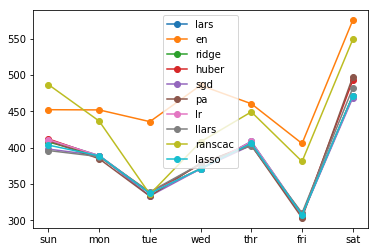

In [6]:
# recursive multi-step forecast with linear algorithms
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
 
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
# prepare a list of ml models
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	models['lasso'] = Lasso()
	models['ridge'] = Ridge()
	models['en'] = ElasticNet()
	models['huber'] = HuberRegressor()
	models['lars'] = Lars()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['ranscac'] = RANSACRegressor()
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	print('Defined %d models' % len(models))
	return models
 
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# make a recursive multi-step forecast
def forecast(model, input_x, n_input):
	yhat_sequence = list()
	input_data = [x for x in input_x]
	for j in range(7):
		# prepare the input data
		X = array(input_data[-n_input:]).reshape(1, n_input)
		# make a one-step forecast
		yhat = model.predict(X)[0]
		# add to the result
		yhat_sequence.append(yhat)
		# add the prediction to the input
		input_data.append(yhat)
	return yhat_sequence
 
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 0] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series
 
# convert history into inputs and outputs
def to_supervised(history, n_input):
	# convert history to a univariate series
	data = to_series(history)
	X, y = list(), list()
	ix_start = 0
	# step over the entire history one time step at a time
	for i in range(len(data)):
		# define the end of the input sequence
		ix_end = ix_start + n_input
		# ensure we have enough data for this instance
		if ix_end < len(data):
			X.append(data[ix_start:ix_end])
			y.append(data[ix_end])
		# move along one time step
		ix_start += 1
	return array(X), array(y)
 
# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
	# prepare data
	train_x, train_y = to_supervised(history, n_input)
	# make pipeline
	pipeline = make_pipeline(model)
	# fit the model
	pipeline.fit(train_x, train_y)
	# predict the week, recursively
	yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
	return yhat_sequence
 
# evaluate a single model
def evaluate_model(model, train, test, n_input):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = sklearn_predict(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores
 
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# prepare the models to evaluate
models = get_models()
n_input = 7
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, model in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(model, train, test, n_input)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

运行示例将评估十种线性算法并总结结果。

在评估每种算法并以单行摘要报告性能时，其中包括整体RMSE以及每步RMSE。

我们可以看到，大多数评估模型运行良好，整周误差均在400千瓦以下，其中随机梯度下降（SGD）回归器的表现最佳，总体均方误差（RMSE）约为383。

还创建了针对10个分类器的每日RMSE的折线图。

我们可以看到，除两种方法外，所有方法都聚集在一起，并且在整个7天的预测中表现均良好。

通过调整某些性能更好的算法的超参数可能会获得更好的结果。此外，更新示例以测试一组非线性和集成算法可能很有趣。

一个有趣的实验可能是在输入更多或更少前几天的情况下，评估一种或几种性能更好的算法的性能。